In [50]:
import gc
import utils
import duckdb
import pandas as pd
import plotly.io as pio
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import torch
from src.dataloader import RelBenchDataLoader
from src.config import CustomConfig
import wandb
import dotenv
from tqdm import tqdm
import os

from src.config import CustomConfig
from src.models.fraudgt import FraudGT
# jupysql is a requirement too

In [132]:
# Matplotlib config
plt.style.use('default')
plt.rcParams.update({
    "font.family":       "serif",
    "font.serif":        ["Times New Roman", "Palatino", "STIX"],
    "mathtext.fontset":  "stix",         # use STIX fonts for math
    "text.usetex":       False,          # or True if you have LaTeX installed

    # 2) Axis titles and tick labels
    "xtick.direction":   "out",
    "ytick.direction":   "out",
    "axes.labelsize":    22,
    "axes.titlesize":    24,
    "xtick.labelsize":   16,
    "ytick.labelsize":   16,

    # 3) Grid style
    "axes.grid":         False,
    "grid.color":        "0.8",          # light grey
    "grid.linestyle":    "--",
    "grid.linewidth":    0.5,

    # 4) Legend styling
    "legend.frameon":    True,
    "legend.framealpha": 0.9,
    "legend.edgecolor":  "0.8",
    "legend.fontsize":   12,
})

In [133]:
utils.db_setup('rel-f1', 'f1.db')
utils.db_setup('rel-avito', 'avito.db')
utils.db_setup('rel-hm', 'hm.db')
utils.db_setup('rel-stack', 'stack.db')
utils.db_setup('rel-trial', 'trial.db')

Catalog Error: Table with name "races" already exists!
Catalog Error: Table with name "AdsInfo" already exists!
Catalog Error: Table with name "article" already exists!
Catalog Error: Table with name "users" already exists!
Catalog Error: Table with name "studies" already exists!


# F1

In [134]:
conn = duckdb.connect('f1.db')
%load_ext sql
%sql conn --alias duckdb
%config SqlMagic.displaycon=False
%config SqlMagic.autopandas=True
pio.renderers.default = 'svg'

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [135]:
%%sql train_df <<
from driver_position_train

In [136]:
%%sql test_df <<
from driver_position_test

In [137]:
%%sql val_df <<
from driver_position_val

In [138]:
train_df.describe()

,date,driverId,position
count,7453,7453.000000,7453.000000
mean,1977-07-01 23:41:38.698510656,262.155105,13.901438
min,1950-06-19 00:00:00,1.000000,1.000000
25%,1964-04-06 00:00:00,108.000000,9.000000
50%,1977-11-24 00:00:00,208.000000,13.333333
75%,1990-05-20 00:00:00,374.000000,18.000000
max,2004-09-03 00:00:00,806.000000,39.000000
std,NaN,192.276916,7.025734


In [139]:
test_df.describe()

,date,driverId,position
count,760,760.000000,760.000000
mean,2013-02-25 03:09:28.421052672,369.565789,11.926206
min,2010-03-02 00:00:00,0.000000,1.000000
25%,2011-06-25 00:00:00,12.000000,8.000000
50%,2013-02-14 00:00:00,109.000000,12.183333
75%,2014-10-07 00:00:00,815.000000,16.000000
max,2016-05-29 00:00:00,837.000000,24.000000
std,NaN,391.605783,5.213817


In [140]:
val_df.describe()

,date,driverId,position
count,499,499.000000,499.000000
mean,2007-07-08 09:31:22.965931776,17.146293,11.083200
min,2005-03-02 00:00:00,0.000000,1.000000
25%,2006-04-26 00:00:00,7.000000,7.550000
50%,2007-08-19 00:00:00,15.000000,11.400000
75%,2008-08-13 00:00:00,21.000000,14.666667
max,2009-10-07 00:00:00,154.000000,22.000000
std,NaN,18.703044,4.640726


In [141]:
driver_pos_train_labels = train_df['position'].to_numpy()
driver_pos_test_labels = test_df['position'].to_numpy()
driver_pos_val_labels = val_df['position'].to_numpy()

In [142]:
def plot_reg_dist(ax, data, xlabel, ylabel, title):
    mean = np.mean(data)
    ax.hist(data, bins='auto', color='#B3EBF2')
    ax.axvline(mean, label='Mean', color='r')
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    ax.set_title(title)

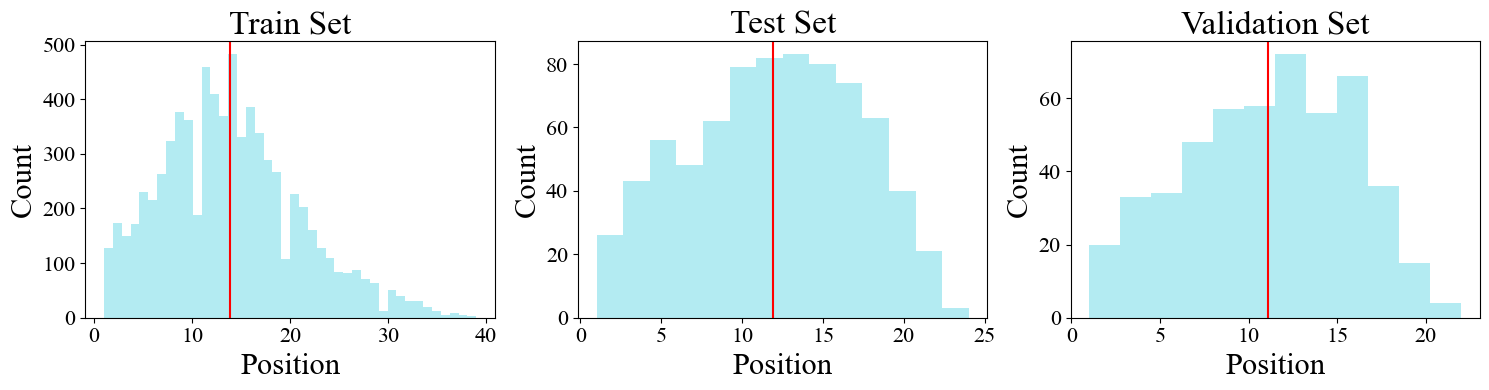

In [143]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax = ax.reshape((-1))

xlabel = 'Position'
ylabel = 'Count'

plot_reg_dist(ax[0], driver_pos_train_labels, xlabel, ylabel, 'Train Set')
plot_reg_dist(ax[1], driver_pos_test_labels, xlabel, ylabel, 'Test Set')
plot_reg_dist(ax[2], driver_pos_val_labels, xlabel, ylabel, 'Validation Set')

plt.tight_layout()
plt.savefig('plots/driver_position_dist.pdf')
plt.show()

## Percentage of labels > 24

In [144]:
over_24 =  driver_pos_train_labels[driver_pos_train_labels >= 24]
percentage = (len(over_24) / len(driver_pos_train_labels))* 100
percentage

9.445860727223938

In [145]:
over_24_mean = over_24.mean()
diff = over_24_mean - 24
diff

np.float64(4.071898674242423)

In [ ]:
api = wandb.Api(timeout=120)
dotenv.load_dotenv()

artifact = api.artifact(dotenv.get_key('../.env', 'WANDB_URL') + '/model_checkpoint:v528', type='model')

config = CustomConfig(run_dir='../runs/', data_dir='../data/', batch_size=1028, num_layers=1, num_neighbors=[150,150], channels=32, dropouts=[0.1,0.2,0.3], edge_features=True)
data_loader = RelBenchDataLoader(
    data_name='f1',
    task_name='driver-position',
    device=torch.device('cuda' if torch.cuda.is_available() else 'cpu'),
    root_dir=config.run_dir,
    batch_size=config.batch_size,
    num_neighbors=config.num_neighbors,
    num_workers=4,
    temporal_strategy=config.temporal_strategy,
    reverse_mp=True,
    add_ports=False,
    ego_ids=False,
    preprocess_graph=False,
)

In [157]:
@torch.no_grad()
def test_model(model, data_loader):
    task = data_loader.task
    model.eval()
    pred_list = []

    for batch in tqdm(data_loader.loader_dict['test']):
        batch = batch.to(config.device)
        pred = model(batch, task.entity_table)


        pred = pred.view(-1) if pred.size(1) == 1 else pred
        pred_list.append(pred.detach().cpu())

    return torch.cat(pred_list, dim=0).numpy()

In [ ]:
from src.models.fraudgt import FraudGT

dir = artifact.download()
fraudgt = FraudGT(data=data_loader.graph,
                  col_stats_dict=data_loader.col_stats_dict,
                  channels=config.channels,
                  out_channels=config.out_channels,
                  dropouts=config.dropouts,
                  num_layers=config.num_layers,
                  num_layers_pre_gt=config.num_layers_pre_gt,
                  head=config.head,
                  edge_features=config.edge_features,
                  torch_frame_model_kwargs={"channels": config.channels, "num_layers": config.num_layers},)

ckpt_path = os.path.join(dir, "epoch_008_mae_3-5287.pt")
state_dict = torch.load(ckpt_path, map_location="cpu")['model_state_dict']
fraudgt.load_state_dict(state_dict)
preds = test_model(fraudgt, data_loader)

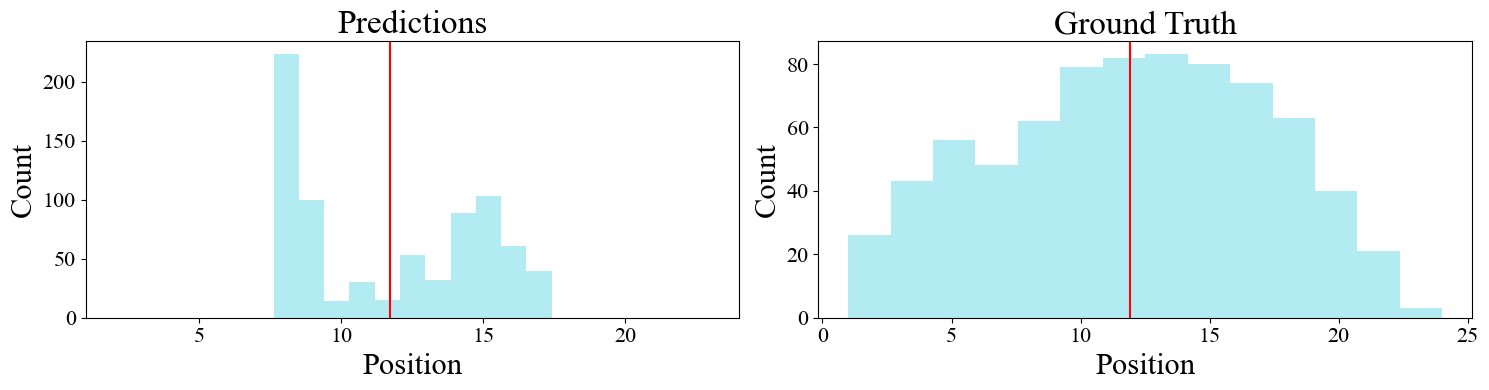

In [159]:
fig, ax = plt.subplots(1, 2, figsize=(15, 4))
plot_reg_dist(ax[0], preds, 'Position', 'Count', 'Predictions')
plot_reg_dist(ax[1], driver_pos_test_labels, 'Position', 'Count', 'Ground Truth')
ax[0].set_xlim(driver_pos_test_labels.min(), driver_pos_test_labels.max())

plt.tight_layout()
plt.savefig('plots/driver_position_preds.pdf')

In [160]:
max = np.max(preds)
max

np.float32(17.407377)

In [161]:
mae = np.array(np.abs(preds - driver_pos_test_labels)).mean()
mae

np.float64(3.9277518843767933)

In [162]:
median = np.median(preds)
median

np.float32(11.847817)

In [163]:
%%sql train_df <<
from driver_top3_train

In [164]:
%%sql test_df <<
from driver_top3_test

In [165]:
%%sql val_df <<
from driver_top3_val

In [166]:
train_df.describe()

,date,driverId,qualifying
count,1353,1353.000000,1353.000000
mean,1998-10-03 08:37:15.033259392,49.562454,0.170732
min,1994-02-28 00:00:00,1.000000,0.000000
25%,1995-05-24 00:00:00,22.000000,0.000000
50%,1997-07-12 00:00:00,49.000000,0.000000
75%,2003-03-13 00:00:00,70.000000,0.000000
max,2004-10-03 00:00:00,115.000000,1.000000
std,NaN,28.320688,0.376413


In [167]:
test_df.describe()

,date,driverId,qualifying
count,726,726.000000,726.000000
mean,2011-08-04 06:56:31.735537152,252.154270,0.176309
min,2010-03-02 00:00:00,0.000000,0.000000
25%,2010-09-28 00:00:00,12.000000,0.000000
50%,2011-07-25 00:00:00,23.000000,0.000000
75%,2012-05-20 00:00:00,808.000000,0.000000
max,2013-03-16 00:00:00,823.000000,1.000000
std,NaN,353.641273,0.381345


In [168]:
val_df.describe()

,date,driverId,qualifying
count,588,588.000000,588.000000
mean,2006-08-23 00:44:04.897959168,17.204082,0.202381
min,2005-03-02 00:00:00,0.000000,0.000000
25%,2005-09-28 00:00:00,10.000000,0.000000
50%,2006-07-25 00:00:00,17.000000,0.000000
75%,2007-06-20 00:00:00,24.000000,0.000000
max,2008-03-16 00:00:00,41.000000,1.000000
std,NaN,10.284000,0.402117


In [169]:
top3_train_labels = train_df.qualifying.to_numpy()
top3_test_labels = test_df.qualifying.to_numpy()
top3_val_labels = test_df.qualifying.to_numpy()

In [170]:
def plot_binary_dist(ax, data, ylabel, title):
    counts = np.bincount(data)           # [num_zero, num_one]
    pct = counts / counts.sum()   # fractions
    bars = ax.bar([0, 1], counts, tick_label=["Negative (0)", "Positive (1)"], color=['#FF6961', '#77DD77'])
    for bar, p in zip(bars, pct):
        ax.text(
            bar.get_x() + bar.get_width()/2,
            bar.get_height(),
            f"{p*100:.1f}%",
            ha="center",
            va="bottom",
            fontweight="bold"
        )
    ax.set_ylabel(ylabel)
    ax.set_title(title)

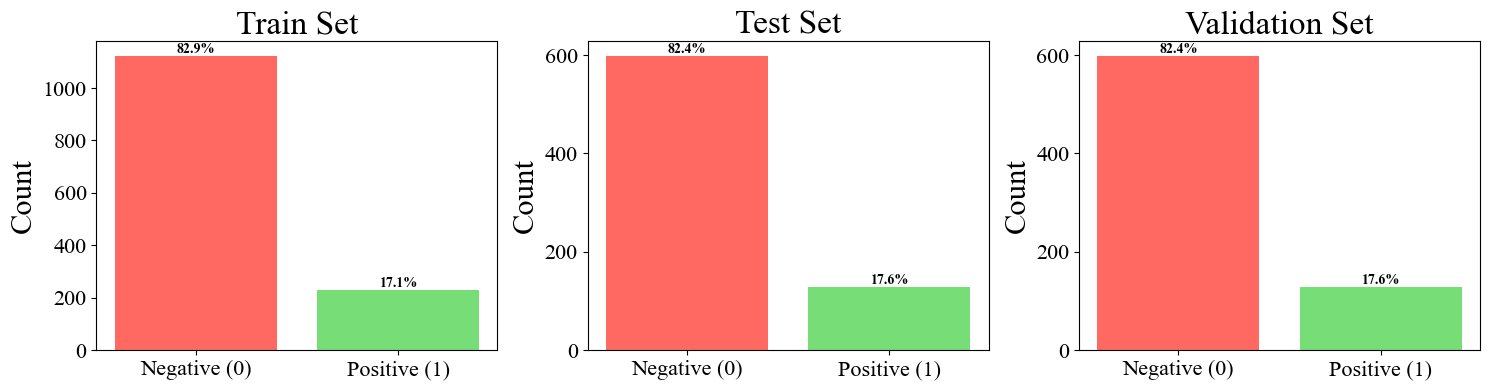

In [171]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax = ax.reshape((-1))

plot_binary_dist(ax[0], top3_train_labels, 'Count', 'Train Set')
plot_binary_dist(ax[1], top3_test_labels, 'Count', 'Test Set')
plot_binary_dist(ax[2], top3_val_labels, 'Count', 'Validation Set')

plt.tight_layout()
plt.savefig('plots/driver_top3_dist.pdf')
plt.show()

In [173]:
%%sql train_df <<
from driver_dnf_train

In [174]:
%%sql test_df <<
from driver_dnf_test

In [175]:
%%sql val_df <<
from driver_dnf_val

In [176]:
dnf_train_labels = train_df.did_not_finish.to_numpy()
dnf_test_labels = test_df.did_not_finish.to_numpy()
dnf_val_labels = val_df.did_not_finish.to_numpy()

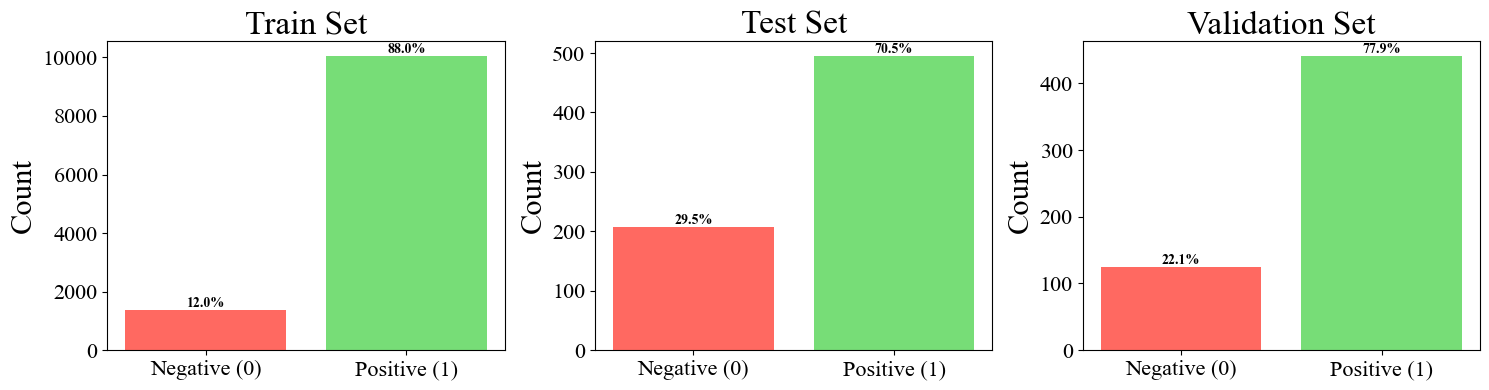

In [177]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax = ax.reshape((-1))

plot_binary_dist(ax[0], dnf_train_labels, 'Count', 'Train Set')
plot_binary_dist(ax[1], dnf_test_labels, 'Count', 'Test Set')
plot_binary_dist(ax[2], dnf_val_labels, 'Count', 'Validation Set')

plt.tight_layout()
plt.savefig('plots/driver_dnf_dist.pdf')
plt.show()

In [178]:
conn.close()
gc.collect()

18268

# HM


In [179]:
conn = duckdb.connect('hm.db')
%load_ext sql
%sql conn --alias duckdb
%config SqlMagic.displaycon=False
%config SqlMagic.autopandas=True
pio.renderers.default = 'svg'

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [180]:
%%sql train_df <<
from user_churn_train

In [181]:
%%sql test_df <<
from user_churn_test

In [182]:
%%sql val_df <<
from user_churn_val

In [183]:
train_df.describe()

,timestamp,customer_id,churn
count,3832692,3.832692e+06,3.832692e+06
mean,2020-03-10 00:31:28.644325632,6.857392e+05,8.187324e-01
min,2019-09-09 00:00:00,0.000000e+00,0.000000e+00
25%,2019-12-02 00:00:00,3.428740e+05,1.000000e+00
50%,2020-03-09 00:00:00,6.855210e+05,1.000000e+00
75%,2020-06-15 00:00:00,1.028411e+06,1.000000e+00
max,2020-08-31 00:00:00,1.371979e+06,1.000000e+00
std,NaN,3.962903e+05,3.852398e-01


In [184]:
test_df.describe()

,timestamp,customer_id,churn
count,74575,7.457500e+04,74575.000000
mean,2020-09-14 00:00:00,6.848040e+05,0.826135
min,2020-09-14 00:00:00,6.000000e+00,0.000000
25%,2020-09-14 00:00:00,3.417305e+05,1.000000
50%,2020-09-14 00:00:00,6.817150e+05,1.000000
75%,2020-09-14 00:00:00,1.028838e+06,1.000000
max,2020-09-14 00:00:00,1.371977e+06,1.000000
std,NaN,3.962824e+05,0.378996


In [185]:
val_df.describe()

,timestamp,customer_id,churn
count,76556,7.655600e+04,76556.000000
mean,2020-09-07 00:00:00,6.840053e+05,0.812804
min,2020-09-07 00:00:00,0.000000e+00,0.000000
25%,2020-09-07 00:00:00,3.402850e+05,1.000000
50%,2020-09-07 00:00:00,6.849775e+05,1.000000
75%,2020-09-07 00:00:00,1.024983e+06,1.000000
max,2020-09-07 00:00:00,1.371975e+06,1.000000
std,NaN,3.960435e+05,0.390072


In [186]:
user_churn_train_labels = train_df.churn.to_numpy()
user_churn_test_labels = test_df.churn.to_numpy()
user_churn_val_labels = val_df.churn.to_numpy()

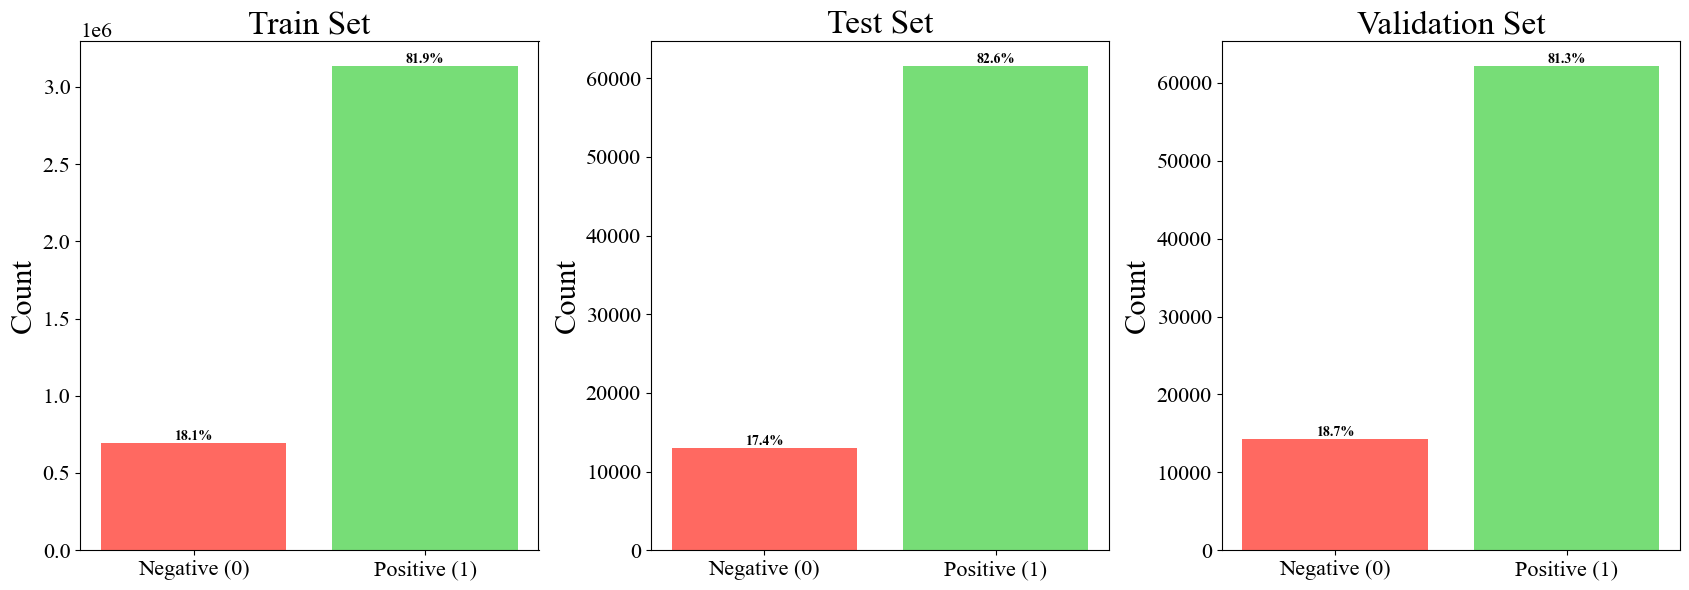

In [187]:
fig, ax = plt.subplots(1, 3, figsize=(17, 6))
ax = ax.reshape((-1))

plot_binary_dist(ax[0], user_churn_train_labels, 'Count', 'Train Set')
plot_binary_dist(ax[1], user_churn_test_labels, 'Count', 'Test Set')
plot_binary_dist(ax[2], user_churn_val_labels, 'Count', 'Validation Set')

plt.tight_layout()
plt.savefig('plots/user_churn_dist.pdf')
plt.show()

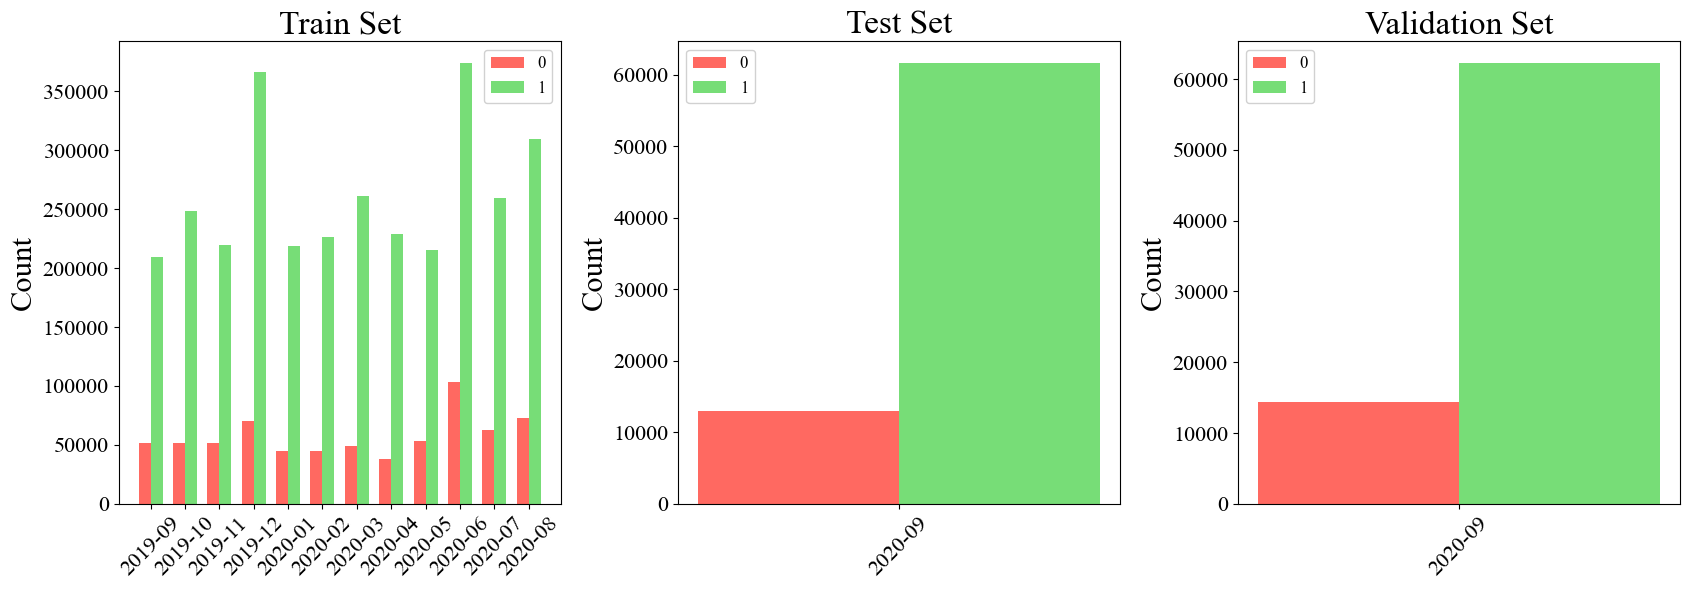

In [188]:
def plot_monthly_splits(
        dfs: dict[str, pd.DataFrame],
        date_col: str = 'timestamp',
        churn_col: str = 'churn',
        figsize: tuple[float, float] = (17, 6)
) -> tuple[plt.Figure, list[plt.Axes]]:
    """
    Plots side-by-side monthly churn distributions for multiple DataFrames.

    Parameters
    ----------
    dfs : dict[str, DataFrame]
        A mapping of subplot title → DataFrame. Each DF must have:
          - a datetime column named `date_col`
          - a binary churn column named `churn_col` (0 or 1)
    date_col : str
        Name of the timestamp column.
    churn_col : str
        Name of the binary churn indicator column.
    figsize : (float, float)
        Figure size passed to plt.subplots().

    Returns
    -------
    fig : matplotlib.figure.Figure
    axes : list of Axes
    """
    n = len(dfs)
    fig, axes = plt.subplots(1, n, figsize=figsize)

    for ax, (title, df) in zip(axes, dfs.items()):
        tmp = df.copy()
        tmp[date_col] = pd.to_datetime(tmp[date_col])
        tmp['month'] = tmp[date_col].dt.to_period('M').dt.to_timestamp()

        # count 0s and 1s per month
        counts = tmp.groupby(['month', churn_col]).size().unstack(fill_value=0)
        months = counts.index
        neg    = counts.get(0, pd.Series(0, index=months))
        pos    = counts.get(1, pd.Series(0, index=months))

        x     = range(len(months))
        width = 0.35

        ax.bar([i-width/2 for i in x], neg,  width, label=f'0', color='#FF6961')
        ax.bar([i+width/2 for i in x], pos,  width, label=f'1', color='#77DD77')

        ax.set_xticks(x)
        ax.set_xticklabels([m.strftime('%Y-%m') for m in months], rotation=45)
        ax.set_title(title)
        ax.legend()
        ax.set_ylabel('Count')

    return fig, axes



splits = {
    'Train Set': train_df,
    'Test Set':  test_df,
    'Validation Set': val_df,
}

fig, axes = plot_monthly_splits(splits)
fig.tight_layout()
plt.savefig('plots/monthly_user_churn_splits.pdf')
plt.show()

In [189]:
# %%sql joined_churn <<
# SELECT
# t.t_dat,
# t.price,
# t.sales_channel_id,
# -- article fields
# a.article_id       AS a_article_id,
# a.product_code,
# a.prod_name,
# a.product_type_no,
# a.product_type_name,
# a.product_group_name,
# a.graphical_appearance_no,
# a.graphical_appearance_name,
# a.colour_group_code,
# a.colour_group_name,
# a.perceived_colour_value_id,
# a.perceived_colour_value_name,
# a.perceived_colour_master_id,
# a.perceived_colour_master_name,
# a.department_no,
# a.department_name,
# a.index_code,
# a.index_name,
# a.index_group_no,
# a.index_group_name,
# a.section_no,
# a.section_name,
# a.garment_group_no,
# a.garment_group_name,
# a.detail_desc,
# -- customer fields
# c.customer_id      AS c_customer_id,
# c.FN,
# c.Active,
# c.club_member_status,
# c.fashion_news_frequency,
# c.age,
# c.postal_code
# FROM transactions AS t
# LEFT JOIN article  AS a ON t.article_id  = a.article_id
# LEFT JOIN customer AS c ON t.customer_id = c.customer_id;


In [190]:
%%sql train_df <<
from item_sales_train

In [191]:
%%sql test_df <<
from item_sales_test

In [192]:
%%sql val_df <<
from item_sales_val

In [193]:
train_df.head()

,timestamp,article_id,sales
0,2020-06-01,83325,2.728000
1,2020-06-01,50838,0.758051
2,2020-06-01,86874,1.337610
3,2020-06-01,89952,1.306220
4,2020-06-01,79129,0.271119


In [194]:
train_df.describe()

,timestamp,article_id,sales
count,5488184,5.488184e+06,5.488184e+06
mean,2020-03-05 12:00:00.000000512,5.277050e+04,7.596521e-02
min,2019-09-09 00:00:00,0.000000e+00,0.000000e+00
25%,2019-12-07 06:00:00,2.638500e+04,0.000000e+00
50%,2020-03-05 12:00:00,5.277050e+04,0.000000e+00
75%,2020-06-02 18:00:00,7.915600e+04,0.000000e+00
max,2020-08-31 00:00:00,1.055410e+05,8.716259e+01
std,NaN,3.046735e+04,4.953213e-01


In [195]:
test_df.describe()

,timestamp,article_id,sales
count,105542,105542.000000,105542.000000
mean,2020-09-14 00:00:00,52770.500000,0.076087
min,2020-09-14 00:00:00,0.000000,0.000000
25%,2020-09-14 00:00:00,26385.250000,0.000000
50%,2020-09-14 00:00:00,52770.500000,0.000000
75%,2020-09-14 00:00:00,79155.750000,0.000000
max,2020-09-14 00:00:00,105541.000000,38.314763
std,NaN,30467.495393,0.582710


In [196]:
val_df.describe()

,timestamp,article_id,sales
count,105542,105542.000000,105542.000000
mean,2020-09-07 00:00:00,52770.500000,0.085690
min,2020-09-07 00:00:00,0.000000,0.000000
25%,2020-09-07 00:00:00,26385.250000,0.000000
50%,2020-09-07 00:00:00,52770.500000,0.000000
75%,2020-09-07 00:00:00,79155.750000,0.000000
max,2020-09-07 00:00:00,105541.000000,40.364915
std,NaN,30467.495393,0.662294


In [197]:
item_sales_train_labels = train_df.sales.to_numpy()
item_sales_test_labels = test_df.sales.to_numpy()
item_sales_val_labels = val_df.sales.to_numpy()

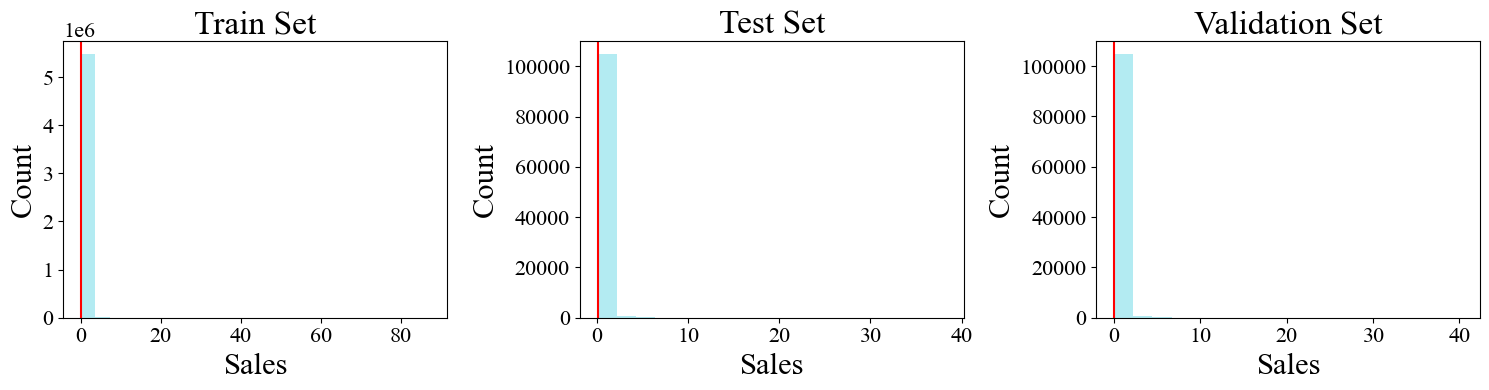

In [198]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax = ax.reshape((-1))

plot_reg_dist(ax[0], item_sales_train_labels, 'Sales', 'Count', 'Train Set')
plot_reg_dist(ax[1], item_sales_test_labels, 'Sales', 'Count', 'Test Set')
plot_reg_dist(ax[2], item_sales_val_labels, 'Sales', 'Count', 'Validation Set')

plt.tight_layout()
plt.savefig('plots/item_sales_dist.pdf')
plt.show()

/var/folders/0x/klqdyhpj427dvg81kxzyfcvm0000gn/T/ipykernel_9367/2367861838.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




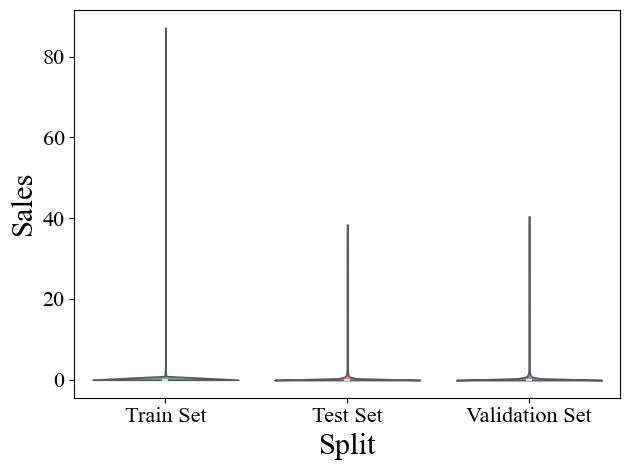

In [199]:
sales = np.concatenate([item_sales_train_labels, item_sales_test_labels, item_sales_val_labels])
sets = (['Train Set'] * len(item_sales_train_labels)) + (['Test Set'] * len(item_sales_test_labels)) + (['Validation Set'] * len(item_sales_val_labels))

df = pd.DataFrame({'Sales': sales, 'Split': sets})

fig, ax = plt.subplots()
sns.violinplot(x='Split', y='Sales', data=df, ax=ax, palette='Set2')

plt.tight_layout()
plt.savefig('plots/item_sales_violinplot.pdf')
plt.show()

In [200]:
def plot_monthly_data(
        dfs: dict[str, pd.DataFrame],
        date_col: str = 'timestamp',
        col: str = 'sales',
        figsize: tuple[float, float] = (17, 6),
        label = ''
) -> tuple[plt.Figure, list[plt.Axes]]:
    """
    Plots side-by-side monthly churn distributions for multiple DataFrames.

    Parameters
    ----------
    dfs : dict[str, DataFrame]
        A mapping of subplot title → DataFrame. Each DF must have:
          - a datetime column named `date_col`
          - a binary churn column named `churn_col` (0 or 1)
    date_col : str
        Name of the timestamp column.
    churn_col : str
        Name of the binary churn indicator column.
    figsize : (float, float)
        Figure size passed to plt.subplots().

    Returns
    -------
    fig : matplotlib.figure.Figure
    axes : list of Axes
    """
    n = len(dfs)
    fig, axes = plt.subplots(1, n, figsize=figsize)

    for ax, (title, df) in zip(axes, dfs.items()):
        tmp = df.copy()
        tmp[date_col] = pd.to_datetime(tmp[date_col])
        tmp['month'] = tmp[date_col].dt.to_period('M').dt.to_timestamp()

        # count 0s and 1s per month
        counts = tmp.groupby(['month', col]).size().unstack(fill_value=0)
        months = counts.index
        neg    = counts.get(0, pd.Series(0, index=months))
        pos    = counts.get(1, pd.Series(0, index=months))

        x     = range(len(months))
        width = 0.35

        ax.bar([i-width/2 for i in x], neg,  width, color='#B3EBF2')

        ax.set_xticks(x)
        ax.set_xticklabels([m.strftime('%Y-%m') for m in months], rotation=45)
        ax.set_title(title)

    axes[0].set_ylabel('Count')
    return fig, axes

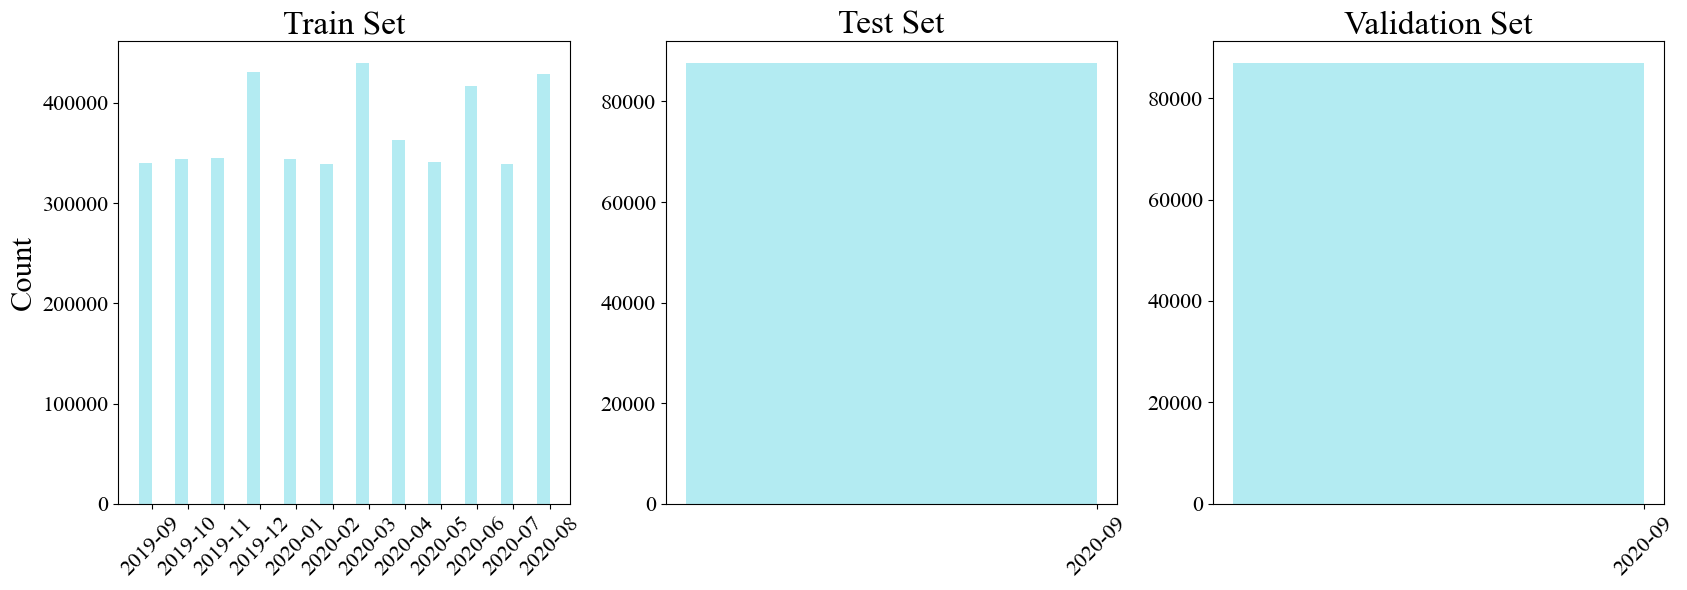

In [201]:
splits = {
    'Train Set': train_df,
    'Test Set':  test_df,
    'Validation Set': val_df,
}

fig, axes = plot_monthly_data(splits, label='Sales')
fig.tight_layout()
plt.savefig('plots/monthly_item_sales.pdf')
plt.show()

In [202]:
%%sql transactions <<
from transactions

In [203]:
transactions.head()

,t_dat,customer_id,article_id,price,sales_channel_id
0,2019-09-07,155,51985,0.010153,1
1,2019-09-07,155,51985,0.010153,1
2,2019-09-07,155,83127,0.042356,1
3,2019-09-07,155,6066,0.005068,1
4,2019-09-07,155,78525,0.033881,1


In [204]:
transactions.describe()

,t_dat,customer_id,article_id,price,sales_channel_id
count,15187287,1.518729e+07,1.518729e+07,1.518729e+07,1.518729e+07
mean,2020-03-18 16:28:04.600337408,6.850272e+05,6.771916e+04,2.827797e-02,1.717938e+00
min,2019-09-07 00:00:00,0.000000e+00,0.000000e+00,1.694915e-05,1.000000e+00
25%,2019-12-14 00:00:00,3.421550e+05,5.389300e+04,1.693220e-02,1.000000e+00
50%,2020-03-31 00:00:00,6.846860e+05,7.619200e+04,2.540678e-02,2.000000e+00
75%,2020-06-21 00:00:00,1.027147e+06,8.843800e+04,3.388136e-02,2.000000e+00
max,2020-09-14 00:00:00,1.371979e+06,1.055390e+05,5.067797e-01,2.000000e+00
std,NaN,3.961050e+05,2.796803e+04,1.910424e-02,4.500032e-01


In [205]:
txns_by_week = conn.execute("""
SELECT
    strftime('%Y-%W', t_dat) AS week,
    COUNT(*) AS num_sales,
    SUM(price) AS sold_amount
FROM
    transactions
GROUP BY
    week
ORDER BY
    week
""").df().sort_values('week')


In [206]:
txns_by_week.head()

,week,num_sales,sold_amount
0,2019-35,76532,2409.290068
1,2019-36,246418,8069.061169
2,2019-37,232278,7860.174966
3,2019-38,423424,13908.877695
4,2019-39,315721,10078.621576


/var/folders/0x/klqdyhpj427dvg81kxzyfcvm0000gn/T/ipykernel_9367/204919090.py:4: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.



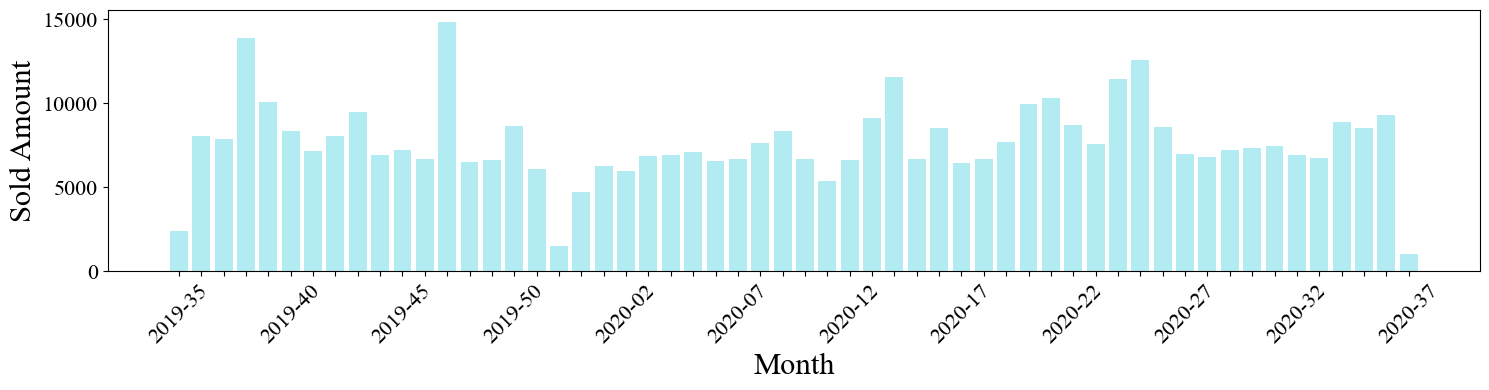

In [207]:
fig, ax = plt.subplots(figsize=(15, 4))

ax.bar(txns_by_week.week, txns_by_week.sold_amount, color='#B3EBF2')
ax.set_xticklabels([m for m in txns_by_week.week], rotation=45)
for idx, label in enumerate(ax.xaxis.get_ticklabels()):
    label.set_visible(idx % 5 == 0)
ax.set_ylabel('Sold Amount')
ax.set_xlabel('Month')


plt.tight_layout()
plt.savefig('plots/item_sales_weekly_transactions.pdf')
plt.show()

In [208]:
conn.close()
gc.collect()

44088

# Avito

In [209]:
conn = duckdb.connect('avito.db')
%load_ext sql
%sql conn --alias duckdb
%config SqlMagic.displaycon=False
%config SqlMagic.autopandas=True
pio.renderers.default = 'svg'

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [210]:
%%sql train_df <<
from user_visits_train

In [211]:
%%sql test_df <<
from user_visits_test

In [212]:
%%sql val_df <<
from user_visits_val

In [213]:
train_df.head()

,UserID,timestamp,num_click
0,38950,2015-04-26,True
1,35404,2015-04-26,True
2,85455,2015-04-26,True
3,2871,2015-04-26,True
4,34600,2015-04-26,True


In [214]:
train_df['num_click'] = train_df['num_click'].astype(int)
test_df['num_click'] = test_df['num_click'].astype(int)
val_df['num_click']= val_df['num_click'].astype(int)

train_df.head()

,UserID,timestamp,num_click
0,38950,2015-04-26,1
1,35404,2015-04-26,1
2,85455,2015-04-26,1
3,2871,2015-04-26,1
4,34600,2015-04-26,1


In [215]:
train_df.describe()

,UserID,timestamp,num_click
count,86619.000000,86619,86619.000000
mean,49188.634145,2015-04-30 03:32:15.718491392,0.905887
min,0.000000,2015-04-26 00:00:00,0.000000
25%,24546.000000,2015-04-26 00:00:00,1.000000
50%,49155.000000,2015-04-30 00:00:00,1.000000
75%,73782.000000,2015-05-04 00:00:00,1.000000
max,98217.000000,2015-05-04 00:00:00,1.000000
std,28340.510626,NaN,0.291988


In [216]:
test_df.describe()

,UserID,timestamp,num_click
count,36129.000000,36129,36129.000000
mean,49140.150267,2015-05-14 00:00:00,0.850591
min,3.000000,2015-05-14 00:00:00,0.000000
25%,24634.000000,2015-05-14 00:00:00,1.000000
50%,49071.000000,2015-05-14 00:00:00,1.000000
75%,73700.000000,2015-05-14 00:00:00,1.000000
max,98139.000000,2015-05-14 00:00:00,1.000000
std,28335.916937,NaN,0.356496


In [217]:
val_df.describe()

,UserID,timestamp,num_click
count,29979.000000,29979,29979.000000
mean,48963.380366,2015-05-08 00:00:00,0.903499
min,3.000000,2015-05-08 00:00:00,0.000000
25%,24184.500000,2015-05-08 00:00:00,1.000000
50%,48899.000000,2015-05-08 00:00:00,1.000000
75%,73513.000000,2015-05-08 00:00:00,1.000000
max,98136.000000,2015-05-08 00:00:00,1.000000
std,28338.941071,NaN,0.295282


In [218]:
user_visits_train_labels = train_df.num_click.to_numpy()
user_visits_test_labels = test_df.num_click.to_numpy()
user_visits_val_labels = val_df.num_click.to_numpy()

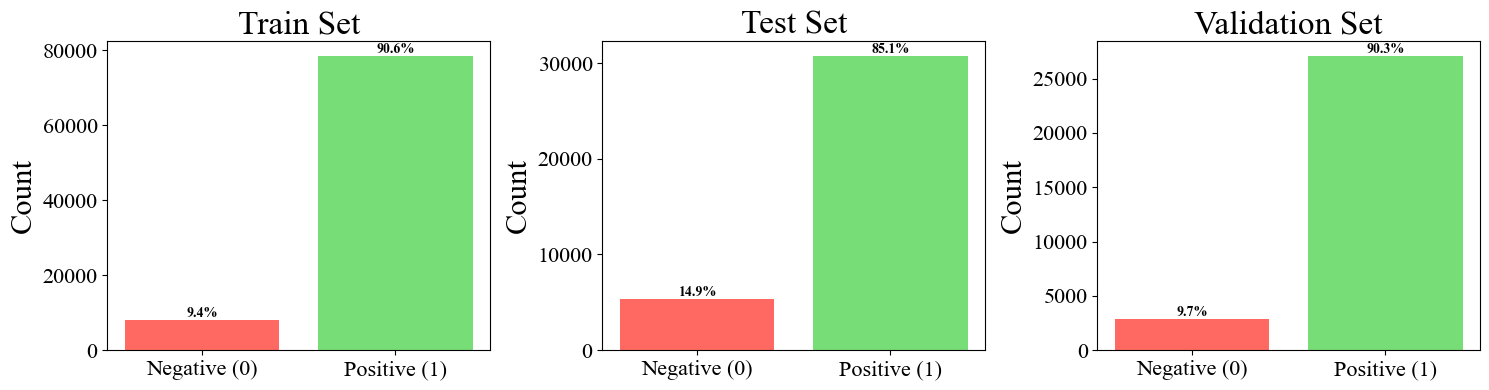

In [219]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax = ax.reshape((-1))

plot_binary_dist(ax[0], user_visits_train_labels, 'Count', 'Train Set')
plot_binary_dist(ax[1], user_visits_test_labels, 'Count', 'Test Set')
plot_binary_dist(ax[2], user_visits_val_labels, 'Count', 'Validation Set')

plt.tight_layout()
plt.savefig('plots/user_visits_dist.pdf')
plt.show()

In [224]:
all_joined = conn.execute("""
SELECT
-- from SearchInfo / SearchStream
SI.SearchID,
SI.UserID,
SI.IPID       AS SearchIPID,
SI.SearchDate,
SI.IsUserLoggedOn,
SI.SearchQuery,
SI.LocationID AS SearchLocationID,
SI.CategoryID AS SearchCategoryID,

SS.AdID,
SS.Position,
SS.ObjectType,
SS.HistCTR,
SS.IsClick,

-- from AdsInfo
A.Price,
A.Title,
A.IsContext,
A.LocationID AS AdLocationID,
A.CategoryID AS AdCategoryID,

-- from Category (via AdCategoryID)
C.Level         AS AdCategoryLevel,
C.ParentCategoryID,
C.SubcategoryID,

-- from Location (via AdLocationID)
L.Level         AS AdLocationLevel,
L.RegionID      AS AdRegionID,
L.CityID        AS AdCityID,

-- from UserInfo
U.UserAgentID,
U.UserAgentOSID,
U.UserAgentFamilyID,
U.UserDeviceID,

-- from VisitStream (may be NULL)
VS.ViewDate     AS VisitDate,

-- from PhoneRequestsStream (may be NULL)
PRS.PhoneRequestDate

FROM SearchStream SS
JOIN SearchInfo       SI  USING (SearchID)
JOIN AdsInfo          A   USING (AdID)
JOIN Category         C   ON A.CategoryID = C.CategoryID
JOIN Location         L   ON A.LocationID = L.LocationID
JOIN UserInfo         U   USING (UserID)
LEFT JOIN VisitStream VS  ON VS.UserID = U.UserID
AND VS.AdID   = A.AdID
LEFT JOIN PhoneRequestsStream PRS
ON PRS.UserID = U.UserID
AND PRS.AdID   = A.AdID
;""").df()

In [225]:
all_joined.columns

Index(['SearchID', 'UserID', 'SearchIPID', 'SearchDate', 'IsUserLoggedOn',
       'SearchQuery', 'SearchLocationID', 'SearchCategoryID', 'AdID',
       'Position', 'ObjectType', 'HistCTR', 'IsClick', 'Price', 'Title',
       'IsContext', 'AdLocationID', 'AdCategoryID', 'AdCategoryLevel',
       'ParentCategoryID', 'SubcategoryID', 'AdLocationLevel', 'AdRegionID',
       'AdCityID', 'UserAgentID', 'UserAgentOSID', 'UserAgentFamilyID',
       'UserDeviceID', 'VisitDate', 'PhoneRequestDate'],
      dtype='object')

In [226]:
all_joined.head()

,SearchID,UserID,SearchIPID,SearchDate,IsUserLoggedOn,SearchQuery,SearchLocationID,SearchCategoryID,AdID,Position,...,SubcategoryID,AdLocationLevel,AdRegionID,AdCityID,UserAgentID,UserAgentOSID,UserAgentFamilyID,UserDeviceID,VisitDate,PhoneRequestDate
0,937059,10029,833500.0,2015-05-05 01:45:50,1.0,None,497,22,122890,8.0,...,47,2.0,18.0,623.0,63091.0,20.0,25.0,2014.0,2015-05-05 01:45:34,NaT
1,1586769,41172,2050404.0,2015-05-11 03:21:14,1.0,None,240,36,122916,7.0,...,6,3.0,55.0,746.0,21088.0,9.0,7.0,2014.0,2015-05-11 03:21:37,NaT
2,1768354,540,1125298.0,2015-05-12 14:02:41,0.0,None,394,34,122940,2.0,...,7,3.0,23.0,1003.0,55731.0,20.0,64.0,2014.0,2015-05-12 14:02:57,NaT
3,1698367,11439,10798.0,2015-05-11 22:47:40,0.0,None,271,50,123124,8.0,...,23,3.0,39.0,2726.0,27016.0,9.0,62.0,2014.0,2015-05-11 22:47:12,NaT
4,1817615,19547,335110.0,2015-05-12 19:44:49,1.0,None,191,38,123194,8.0,...,44,3.0,84.0,2995.0,22293.0,20.0,25.0,2014.0,2015-05-12 19:45:10,NaT


In [227]:
all_joined.size

118785150

In [228]:
visit_stream = conn.execute("SELECT * FROM visitstream").df()
visit_stream.head()

,UserID,IPID,AdID,ViewDate
0,20812,965680.0,2007763,2015-04-25 04:07:16
1,9281,76075.0,62087,2015-04-25 08:07:31
2,9281,76075.0,4459210,2015-04-25 08:08:38
3,9281,76075.0,3366402,2015-04-25 08:12:30
4,9281,76075.0,5742539,2015-04-25 08:13:01


In [229]:
# visit_stream = conn.execute("""
# WITH visits AS (
#     SELECT
#         UserID,
#         AdID,
#         ViewDate
#     FROM visitstream
# )
# SELECT
#     v1.UserID,
#     v1.ViewDate,
#     CASE
#         WHEN COUNT(DISTINCT v2.AdID) > 1 THEN 1
#         ELSE 0
#         END AS will_visit_multiple_ads_next_4d
# FROM visits v1
#          JOIN visits v2
#               ON v2.UserID = v1.UserID
#                   AND v2.ViewDate BETWEEN v1.ViewDate
#                      AND v1.ViewDate + INTERVAL '4' DAY
# GROUP BY
#     v1.UserID,
#     v1.ViewDate;
# """).df()
# visit_stream.head()


In [230]:
visit_stream = conn.execute("""
WITH sortedvisitstream AS (SELECT * FROM visitstream ORDER BY ViewDate ASC)
SELECT UserID, COUNT(DISTINCT(AdID)) FROM sortedvisitstream GROUP BY UserID
""").df()
visit_stream.head()

,UserID,count(DISTINCT AdID)
0,78009,187
1,80903,21
2,79434,448
3,70033,2225
4,2108,7


In [231]:
visit_stream.groupby('UserID')

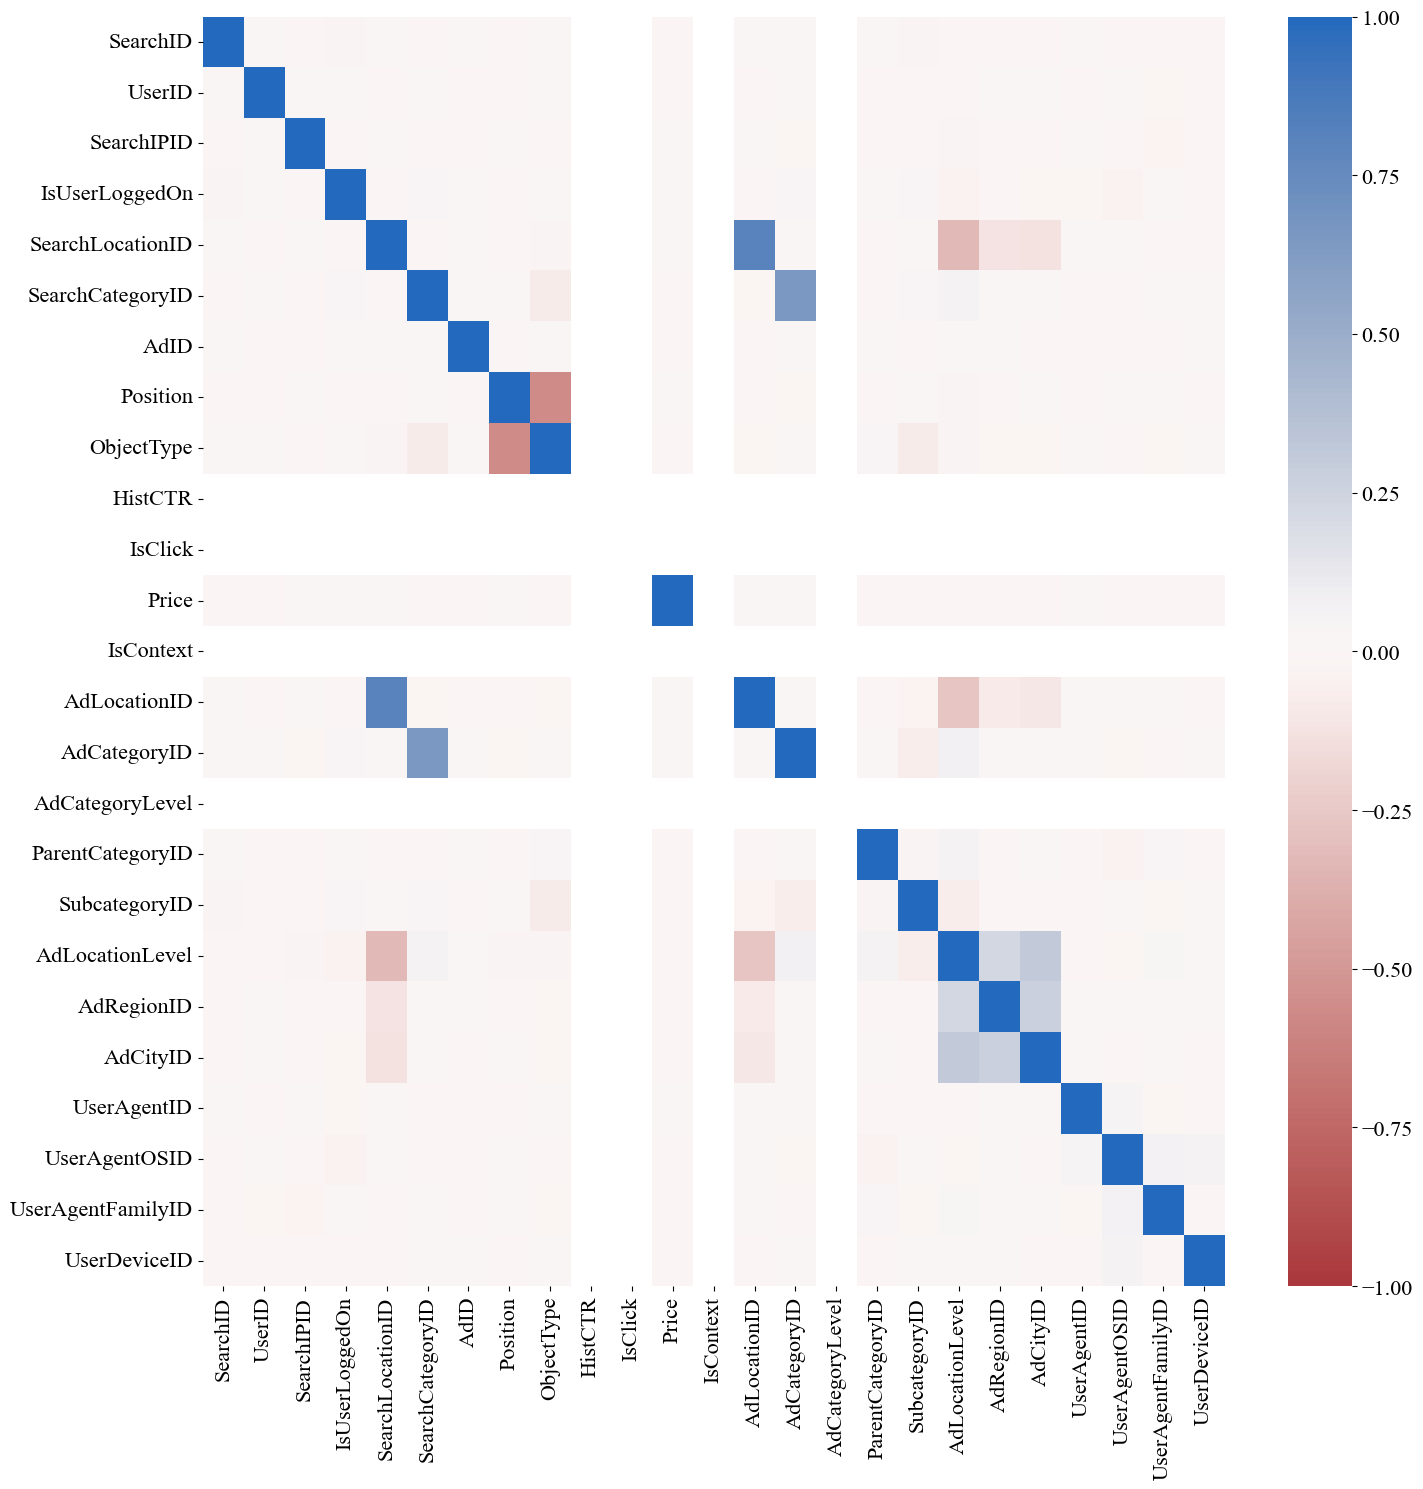

In [232]:
plt.subplots(figsize=(15,15))
sns.heatmap(all_joined.corr(numeric_only=True), cmap = 'vlag_r', vmin = -1, vmax = 1)

plt.tight_layout()
plt.savefig('plots/avito_user_visits.pdf')
plt.show()

In [233]:
%%sql train_df <<
from ad_ctr_train

In [234]:
%%sql test_df <<
from ad_ctr_test

In [235]:
%%sql val_df <<
from ad_ctr_val

In [236]:
train_df.describe()

,AdID,timestamp,num_click
count,5.100000e+03,5100,5100.000000
mean,3.015543e+06,2015-04-30 09:24:42.352941312,0.044565
min,2.410000e+02,2015-04-26 00:00:00,0.000517
25%,1.560212e+06,2015-04-26 00:00:00,0.008197
50%,3.022963e+06,2015-04-30 00:00:00,0.017857
75%,4.506267e+06,2015-05-04 00:00:00,0.041667
max,5.928415e+06,2015-05-04 00:00:00,1.000000
std,1.695615e+06,NaN,0.095675


In [237]:
test_df.describe()

,AdID,timestamp,num_click
count,1.816000e+03,1816,1816.000000
mean,2.953207e+06,2015-05-14 00:00:00,0.052210
min,4.659000e+03,2015-05-14 00:00:00,0.000847
25%,1.483985e+06,2015-05-14 00:00:00,0.008736
50%,2.926594e+06,2015-05-14 00:00:00,0.018913
75%,4.436748e+06,2015-05-14 00:00:00,0.046032
max,5.919483e+06,2015-05-14 00:00:00,1.000000
std,1.703636e+06,NaN,0.109783


In [238]:
val_df.describe()

,AdID,timestamp,num_click
count,1.766000e+03,1766,1766.000000
mean,3.011808e+06,2015-05-08 00:00:00,0.048414
min,7.344000e+03,2015-05-08 00:00:00,0.000913
25%,1.529616e+06,2015-05-08 00:00:00,0.007897
50%,2.978298e+06,2015-05-08 00:00:00,0.017911
75%,4.485061e+06,2015-05-08 00:00:00,0.045455
max,5.928415e+06,2015-05-08 00:00:00,1.000000
std,1.717176e+06,NaN,0.099229


In [239]:
ad_ctr_train_labels = train_df.num_click.to_numpy()
ad_ctr_test_labels = test_df.num_click.to_numpy()
ad_ctr_val_labels = val_df.num_click.to_numpy()

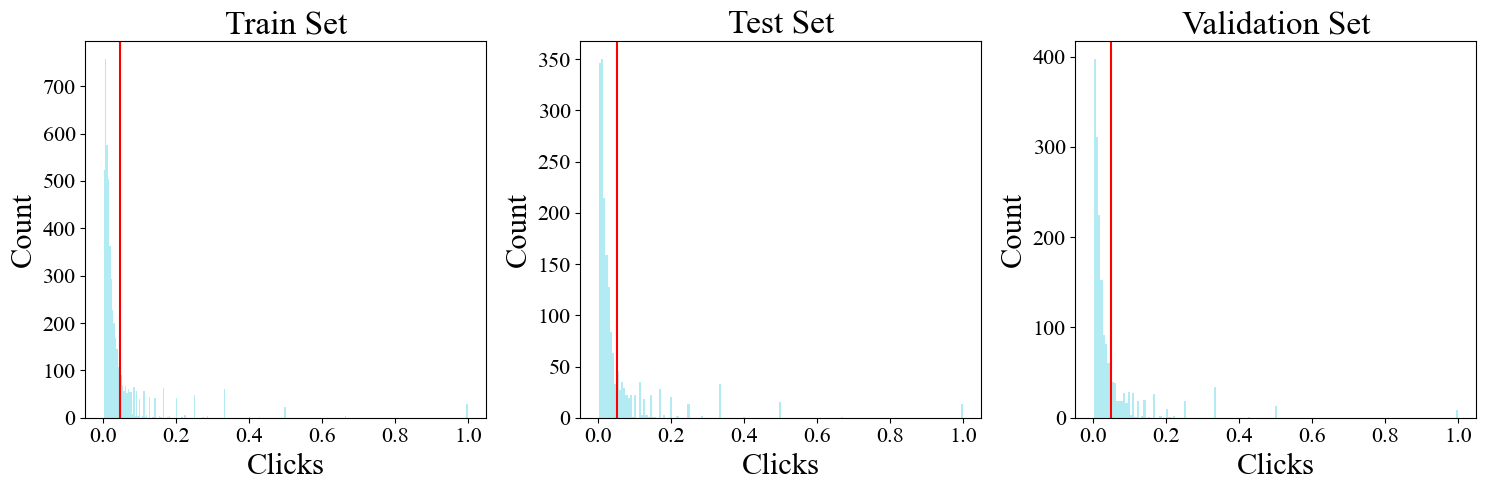

In [240]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax = ax.reshape((-1))

plot_reg_dist(ax[0], ad_ctr_train_labels, 'Clicks', 'Count', 'Train Set')
plot_reg_dist(ax[1], ad_ctr_test_labels, 'Clicks', 'Count', 'Test Set')
plot_reg_dist(ax[2], ad_ctr_val_labels, 'Clicks', 'Count', 'Validation Set')

plt.tight_layout()
plt.savefig('plots/ad_ctr_dist.pdf')
plt.show()

/var/folders/0x/klqdyhpj427dvg81kxzyfcvm0000gn/T/ipykernel_9367/844623360.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




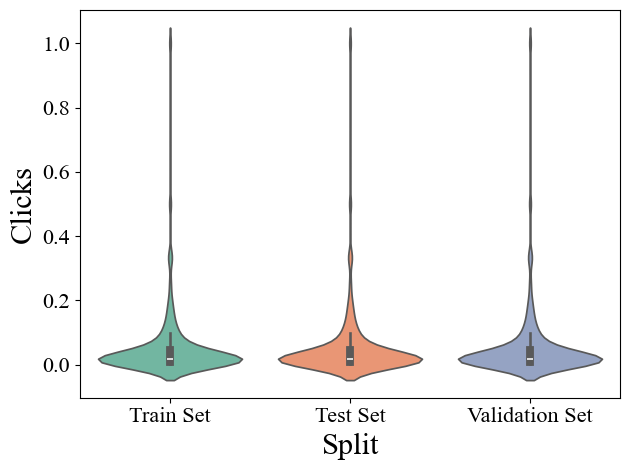

In [241]:
clicks = np.concatenate([ad_ctr_test_labels, ad_ctr_test_labels, ad_ctr_test_labels])
sets = (['Train Set'] * len(ad_ctr_test_labels)) + (['Test Set'] * len(ad_ctr_test_labels)) + (['Validation Set'] * len(ad_ctr_test_labels))

df = pd.DataFrame({'Clicks': clicks, 'Split': sets})

fig, ax = plt.subplots()
sns.violinplot(x='Split', y='Clicks', data=df, ax=ax, palette='Set2')

plt.tight_layout()
plt.savefig('plots/ad_ctr_violinplot.pdf')
plt.show()

In [242]:
conn.close()
gc.collect()

61495

# Trial


In [243]:
conn = duckdb.connect('trial.db')
%load_ext sql
%sql conn --alias duckdb
%config SqlMagic.displaycon=False
%config SqlMagic.autopandas=True
pio.renderers.default = 'svg'

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [244]:
%%sql train_df <<
from study_outcome_train

In [245]:
%%sql test_df <<
from study_outcome_test

In [246]:
%%sql val_df <<
from study_outcome_val

In [247]:
train_df.describe()

,timestamp,nct_id,outcome
count,11994,11994.000000,11994.000000
mean,2013-09-16 11:37:11.315657984,92576.491662,0.637569
min,2001-01-05 00:00:00,49.000000,0.000000
25%,2011-01-03 00:00:00,46118.000000,0.000000
50%,2014-01-02 00:00:00,86324.500000,1.000000
75%,2017-01-01 00:00:00,135772.750000,1.000000
max,2019-01-01 00:00:00,217762.000000,1.000000
std,NaN,54858.809190,0.480722


In [248]:
test_df.describe()

,timestamp,nct_id,outcome
count,825,825.000000,825.000000
mean,2021-01-01 00:00:00,199249.295758,0.585455
min,2021-01-01 00:00:00,14479.000000,0.000000
25%,2021-01-01 00:00:00,177202.000000,0.000000
50%,2021-01-01 00:00:00,211407.000000,1.000000
75%,2021-01-01 00:00:00,231650.000000,1.000000
max,2021-01-01 00:00:00,249609.000000,1.000000
std,NaN,43653.289978,0.492942


In [249]:
val_df.describe()

,timestamp,nct_id,outcome
count,960,960.000000,960.000000
mean,2020-01-01 00:00:00,185996.045833,0.584375
min,2020-01-01 00:00:00,2301.000000,0.000000
25%,2020-01-01 00:00:00,164325.000000,0.000000
50%,2020-01-01 00:00:00,197395.000000,1.000000
75%,2020-01-01 00:00:00,215933.750000,1.000000
max,2020-01-01 00:00:00,234361.000000,1.000000
std,NaN,40056.595518,0.493086


In [250]:
study_outcome_train_labels = train_df.outcome.to_numpy()
study_outcome_test_labels = test_df.outcome.to_numpy()
study_outcome_val_labels = val_df.outcome.to_numpy()

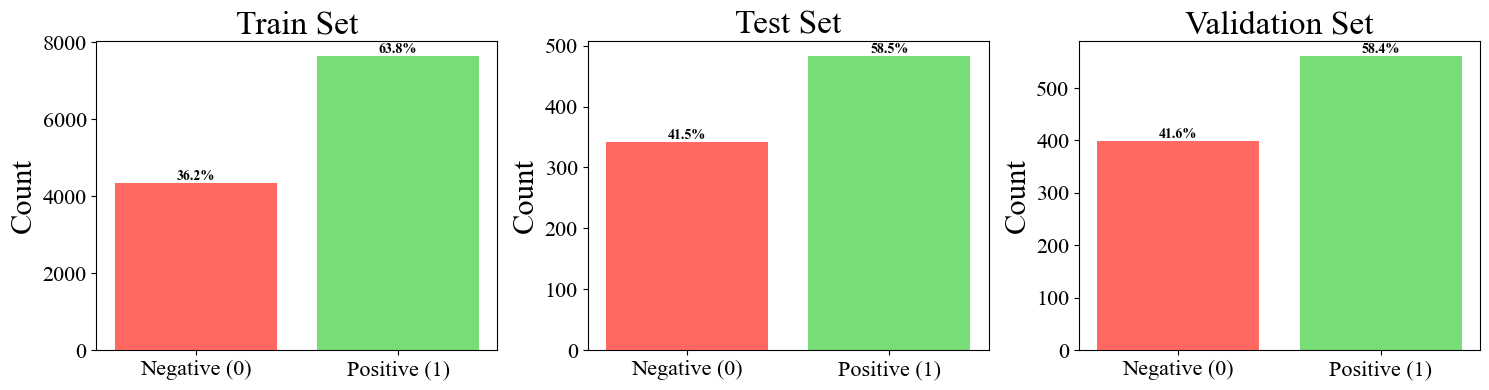

In [251]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax = ax.reshape((-1))

plot_binary_dist(ax[0], study_outcome_train_labels, 'Count', 'Train Set')
plot_binary_dist(ax[1], study_outcome_test_labels, 'Count', 'Test Set')
plot_binary_dist(ax[2], study_outcome_val_labels, 'Count', 'Validation Set')

plt.tight_layout()
plt.savefig('plots/study_outcome_dist.pdf')
plt.show()

In [252]:
%%sql train_df <<
from site_success_train

In [253]:
%%sql test_df <<
from site_success_test

In [254]:
%%sql val_df <<
from site_success_val

In [255]:
train_df.describe()

,timestamp,facility_id,success_rate
count,151407,151407.000000,151407.000000
mean,2014-12-05 14:37:31.346371072,148505.767996,0.442396
min,2001-01-05 00:00:00,1.000000,0.000000
25%,2013-01-02 00:00:00,35745.500000,0.000000
50%,2015-01-02 00:00:00,110521.000000,0.000000
75%,2018-01-01 00:00:00,254082.500000,1.000000
max,2019-01-01 00:00:00,453211.000000,1.000000
std,NaN,131004.067856,0.475863


In [256]:
test_df.describe()

,timestamp,facility_id,success_rate
count,22617,22617.000000,22617.000000
mean,2021-01-01 00:00:00,155604.373613,0.462222
min,2021-01-01 00:00:00,1.000000,0.000000
25%,2021-01-01 00:00:00,34393.000000,0.000000
50%,2021-01-01 00:00:00,118894.000000,0.166667
75%,2021-01-01 00:00:00,259463.000000,1.000000
max,2021-01-01 00:00:00,453227.000000,1.000000
std,NaN,137467.358421,0.481231


In [257]:
val_df.describe()

,timestamp,facility_id,success_rate
count,19740,19740.000000,19740.000000
mean,2020-01-01 00:00:00,158304.955218,0.474937
min,2020-01-01 00:00:00,1.000000,0.000000
25%,2020-01-01 00:00:00,36905.750000,0.000000
50%,2020-01-01 00:00:00,128224.500000,0.400000
75%,2020-01-01 00:00:00,269598.500000,1.000000
max,2020-01-01 00:00:00,452806.000000,1.000000
std,NaN,130859.318094,0.477706


In [258]:
site_success_train_labels = train_df.success_rate.to_numpy()
site_success_test_labels = test_df.success_rate.to_numpy()
site_success_val_labels = val_df.success_rate.to_numpy()

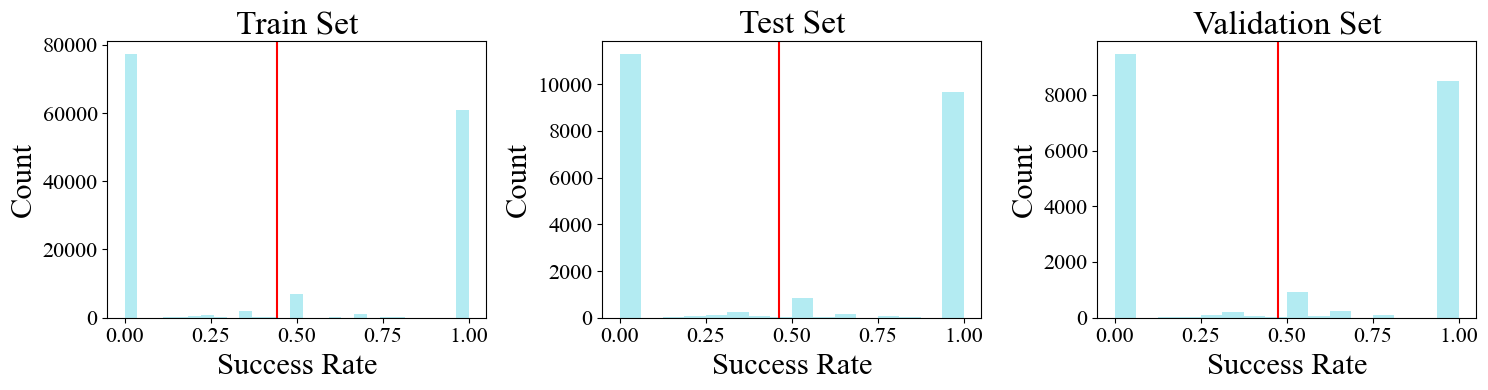

In [259]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax = ax.reshape((-1))

plot_reg_dist(ax[0], site_success_train_labels, 'Success Rate', 'Count', 'Train Set')
plot_reg_dist(ax[1], site_success_test_labels, 'Success Rate', 'Count', 'Test Set')
plot_reg_dist(ax[2], site_success_val_labels, 'Success Rate', 'Count', 'Validation Set')

plt.tight_layout()
plt.savefig('plots/site_success_dist.pdf')
plt.show()

/var/folders/0x/klqdyhpj427dvg81kxzyfcvm0000gn/T/ipykernel_9367/1627231276.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




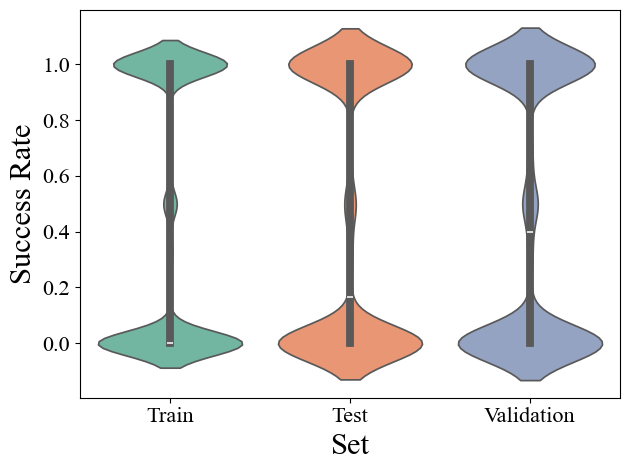

In [260]:
success_rate = np.concatenate([site_success_train_labels, site_success_test_labels, site_success_val_labels])
sets = (['Train'] * len(site_success_train_labels)) + (['Test'] * len(site_success_test_labels)) + (['Validation'] * len(site_success_val_labels))

df = pd.DataFrame({'Success Rate': success_rate, 'Set': sets})

fig, ax = plt.subplots()
sns.violinplot(x='Set', y='Success Rate', data=df, ax=ax, palette='Set2')

plt.tight_layout()
plt.savefig('plots/site_success_violinplot.pdf')
plt.show()

In [261]:
%%sql train_df <<
from study_adverse_train

In [262]:
%%sql test_df <<
from study_adverse_test

In [263]:
%%sql val_df <<
from study_adverse_val

In [264]:
train_df.describe()

,timestamp,nct_id,num_of_adverse_events
count,43335,43335.000000,43335.000000
mean,2013-10-16 16:54:19.813083904,92183.386270,39.843268
min,2001-01-05 00:00:00,37.000000,0.000000
25%,2011-01-03 00:00:00,45384.000000,0.000000
50%,2014-01-02 00:00:00,86129.000000,2.000000
75%,2017-01-01 00:00:00,134732.500000,15.000000
max,2019-01-01 00:00:00,218391.000000,28085.000000
std,NaN,55048.973537,339.110533


In [265]:
test_df.describe()

,timestamp,nct_id,num_of_adverse_events
count,3098,3098.000000,3098.000000
mean,2021-01-01 00:00:00.000000256,198118.268238,57.930278
min,2021-01-01 00:00:00,315.000000,0.000000
25%,2021-01-01 00:00:00,174176.500000,0.000000
50%,2021-01-01 00:00:00,213002.500000,3.000000
75%,2021-01-01 00:00:00,233620.750000,24.000000
max,2021-01-01 00:00:00,249609.000000,5978.000000
std,NaN,47412.398715,249.726540


In [266]:
val_df.describe()

,timestamp,nct_id,num_of_adverse_events
count,3596,3596.000000,3596.000000
mean,2020-01-01 00:00:00.000000256,185187.685206,57.082870
min,2020-01-01 00:00:00,225.000000,0.000000
25%,2020-01-01 00:00:00,164685.250000,0.000000
50%,2020-01-01 00:00:00,197525.000000,2.000000
75%,2020-01-01 00:00:00,217057.500000,18.000000
max,2020-01-01 00:00:00,234821.000000,17245.000000
std,NaN,43167.668795,391.170094


In [267]:
study_adverse_train_labels = train_df.num_of_adverse_events.to_numpy()
study_adverse_test_labels = test_df.num_of_adverse_events.to_numpy()
study_adverse_val_labels = val_df.num_of_adverse_events.to_numpy()

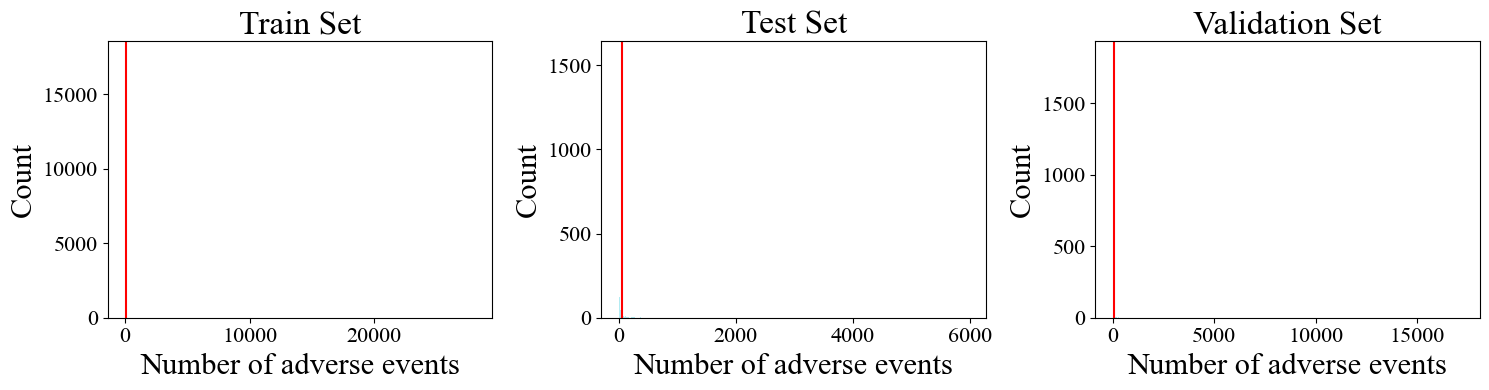

In [268]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax = ax.reshape((-1))

plot_reg_dist(ax[0], study_adverse_train_labels, 'Number of adverse events', 'Count', 'Train Set')
plot_reg_dist(ax[1], study_adverse_test_labels, 'Number of adverse events', 'Count', 'Test Set')
plot_reg_dist(ax[2], study_adverse_val_labels, 'Number of adverse events', 'Count', 'Validation Set')

plt.tight_layout()
plt.savefig('plots/study_adverse_dist.pdf')
plt.show()

/var/folders/0x/klqdyhpj427dvg81kxzyfcvm0000gn/T/ipykernel_9367/3800053831.py:7: FutureWarning:



Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.




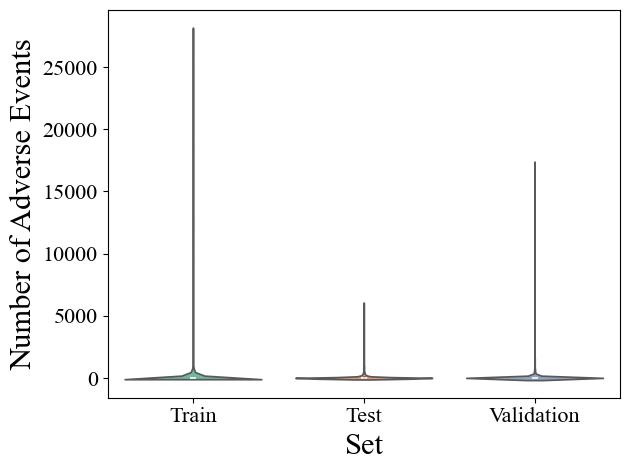

In [269]:
adverse = np.concatenate([study_adverse_train_labels, study_adverse_test_labels, study_adverse_val_labels])
sets = (['Train'] * len(study_adverse_train_labels)) + (['Test'] * len(study_adverse_test_labels)) + (['Validation'] * len(study_adverse_val_labels))

df = pd.DataFrame({'Number of Adverse Events': adverse, 'Set': sets})

fig, ax = plt.subplots()
sns.violinplot(x='Set', y='Number of Adverse Events', data=df, ax=ax, palette='Set2')

plt.tight_layout()
plt.savefig('plots/study_adverse_violinplot.pdf')
plt.show()

## Predicting train median for the test data

In [270]:
adverse = test_df.num_of_adverse_events.to_numpy()
train_median = np.median(train_df.num_of_adverse_events.to_numpy())
test_median = np.median(test_df.num_of_adverse_events.to_numpy())
preds = np.full_like(adverse, fill_value=train_median)
MAE = np.mean(np.abs(adverse - preds))

print("Mean Absolute Error:", MAE)
print("Train Median:", train_median)
print("Test Median:", test_median)

Mean Absolute Error: 57.53324725629438
Train Median: 2.0
Test Median: 3.0


In [271]:
conn.close()
gc.collect()

2488481

# Stack


In [272]:
conn = duckdb.connect('stack.db')
%load_ext sql
%sql conn --alias duckdb
%config SqlMagic.displaycon=False
%config SqlMagic.autopandas=True
pio.renderers.default = 'svg'

The sql extension is already loaded. To reload it, use:
  %reload_ext sql


In [273]:
%%sql train_df <<
from user_engagement_train

In [274]:
%%sql test_df <<
from user_engagement_test

In [275]:
%%sql val_df <<
from user_engagement_val

In [276]:
train_df.describe()

,timestamp,OwnerUserId,contribution
count,1360850,1.360850e+06,1.360850e+06
mean,2017-11-13 17:06:43.704743680,5.871405e+04,4.998347e-02
min,2009-04-16 00:00:00,0.000000e+00,0.000000e+00
25%,2016-07-07 00:00:00,1.687100e+04,0.000000e+00
50%,2018-04-05 00:00:00,4.198400e+04,0.000000e+00
75%,2019-07-04 00:00:00,8.599100e+04,0.000000e+00
max,2020-07-02 00:00:00,2.525400e+05,1.000000e+00
std,NaN,5.317730e+04,2.179109e-01


In [277]:
test_df.describe()

,timestamp,OwnerUserId,contribution
count,88137,88137.000000,88137.000000
mean,2021-01-01 00:00:00,104481.995121,0.027355
min,2021-01-01 00:00:00,0.000000,0.000000
25%,2021-01-01 00:00:00,37569.000000,0.000000
50%,2021-01-01 00:00:00,88666.000000,0.000000
75%,2021-01-01 00:00:00,169146.000000,0.000000
max,2021-01-01 00:00:00,255358.000000,1.000000
std,NaN,75397.114417,0.163117


In [278]:
val_df.describe()

,timestamp,OwnerUserId,contribution
count,85838,85838.000000,85838.000000
mean,2020-10-01 00:00:00,100932.342016,0.028088
min,2020-10-01 00:00:00,0.000000,0.000000
25%,2020-10-01 00:00:00,36492.500000,0.000000
50%,2020-10-01 00:00:00,85743.500000,0.000000
75%,2020-10-01 00:00:00,163466.250000,0.000000
max,2020-10-01 00:00:00,252669.000000,1.000000
std,NaN,72878.547556,0.165225


In [279]:
user_engagement_train_labels = train_df.contribution.to_numpy()
user_engagement_test_labels = test_df.contribution.to_numpy()
user_engagement_val_labels = val_df.contribution.to_numpy()

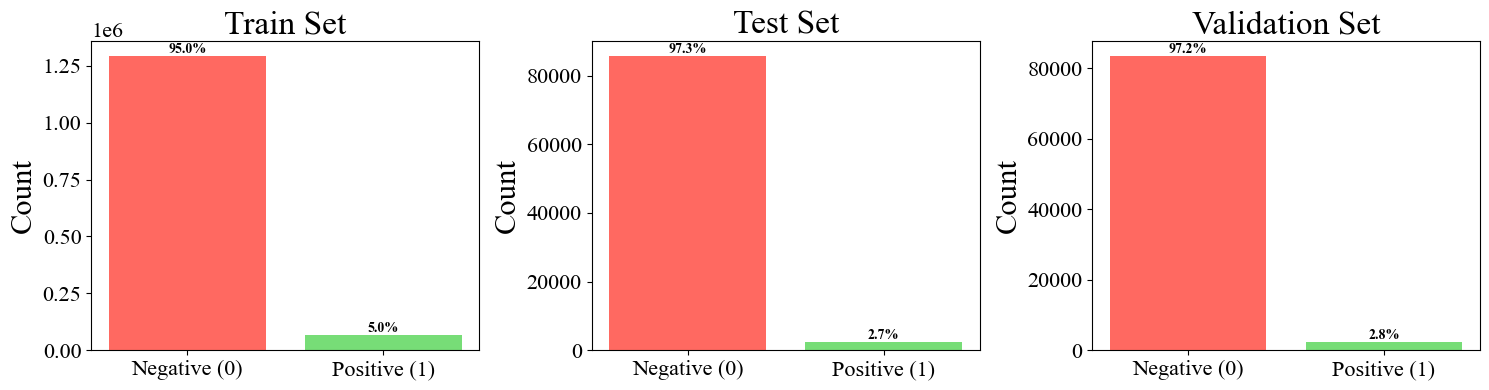

In [280]:
fig, ax = plt.subplots(1, 3, figsize=(15, 4))
ax = ax.reshape((-1))

plot_binary_dist(ax[0], user_engagement_train_labels, 'Count', 'Train Set')
plot_binary_dist(ax[1], user_engagement_test_labels, 'Count', 'Test Set')
plot_binary_dist(ax[2], user_engagement_val_labels, 'Count', 'Validation Set')

plt.tight_layout()
plt.savefig('plots/user_engagement_dist.pdf')
plt.show()

## Predicting all 0's

In [281]:
from sklearn.metrics import roc_auc_score

ground_truth = test_df.contribution.to_numpy()
preds = np.zeros(len(ground_truth))

roc_auc_score = roc_auc_score(ground_truth, preds)
roc_auc_score

np.float64(0.5)

In [282]:
conn.execute("SHOW TABLES").df().loc[lambda d: ~d[d.columns[0]].str.contains("test|train|val", case=False, na=False)].head(10)

,name
0,badges
1,comments
2,postHistory
6,posts
13,users
14,votes


In [ ]:
# all_joined = conn.execute("""
#
#                           SELECT
# -- the post itself
# p.Id              AS post_id,
# p.PostTypeId,
# p.AcceptedAnswerId,
# p.ParentId,
# p.CreationDate    AS post_created,
# p.Body,
# p.Title,
# p.Tags,
# p.OwnerUserId,
#
# -- the post’s author
# u_owner.AccountId    AS owner_account,
# u_owner.CreationDate AS owner_since,
# u_owner.AboutMe      AS owner_bio,
#
# -- comments on the post
# c.Id               AS comment_id,
# c.Text             AS comment_text,
# c.CreationDate     AS comment_created,
# c.UserId           AS commenter_id,
#
# -- edit/history entries on the post
# ph.Id              AS history_id,
# ph.PostHistoryTypeId,
# ph.ContentLicense,
# ph.Text            AS history_text,
# ph.CreationDate    AS history_created,
# ph.UserId          AS history_user_id,
#
# -- votes on the post
# v.Id               AS vote_id,
# v.VoteTypeId,
# v.UserId           AS voter_id,
# v.CreationDate     AS vote_created,
#
# -- badges awarded to the post’s owner
# b.Id               AS badge_id,
# b.Class            AS badge_class,
# b.Date             AS badge_awarded,
# b.TagBased
#
#                           FROM posts p
#
# -- author/profile
#                                    LEFT JOIN users        u_owner ON u_owner.Id       = p.OwnerUserId
#
# -- all the “child” tables on posts
#                                    LEFT JOIN comments     c       ON c.PostId          = p.Id
#                                    LEFT JOIN postHistory  ph      ON ph.PostId         = p.Id
#                                    LEFT JOIN votes        v       ON v.PostId          = p.Id
#
# -- badges for the owner
#                                    LEFT JOIN badges       b       ON b.UserId          = p.OwnerUserId
#                           ;
# """).df()

In [284]:
# plt.subplots(figsize=(15,15))
# sns.heatmap(all_joined.corr(numeric_only=True), cmap = 'vlag_r', vmin = -1, vmax = 1)
#
# plt.tight_layout()
# plt.savefig('plots/user_engagement.pdf')
# plt.show()

In [285]:
conn.close()
gc.collect()

0